In [1]:
import os #menyediakan fungsi-fungsi untuk berinteraksi dengan sistem operasi. 
import numpy as np #struktur data dan fungsi matematika yang efisien untuk bekerja dengan array multidimensi
import pandas as pd #untuk manipulasi dan analisis data. Pandas menyediakan struktur data yang mudah digunakan, seperti DataFrame, untuk memanipulasi dan menganalisis data tabular
import matplotlib.pyplot as plt #untuk membuat grafik, plot, histogram, dan visualisasi data lainnya
import seaborn as sb #digunakan untuk membuat grafik yang indah dan informatif
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Link DataSet
# https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1
os.listdir('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset')

['dataset', 'test', 'train']

# Load Dataset

In [3]:
TRAIN_PATH = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train"
TEST_PATH = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test"
BATCH_SIZE = 32 #menentukan ukuran batch yang akan digunakan saat melatih mode
EPOCHS = 30 #menentukan jumlah epoch (iterasi melalui seluruh dataset) yang akan digunakan selama pelatihan model
LEARNING_RATE = 0.001 
IMG_SHAPE= (224,224)
## train generator 
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                 zoom_range=0.2,
                                 shear_range=0.3,
                                 horizontal_flip=True,
                                 brightness_range=[0.5,1.5])
#test generator 
test_datagen = ImageDataGenerator(rescale=1/255.0)

#generate data from train and test directories 
train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary")

test_gen = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary")


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


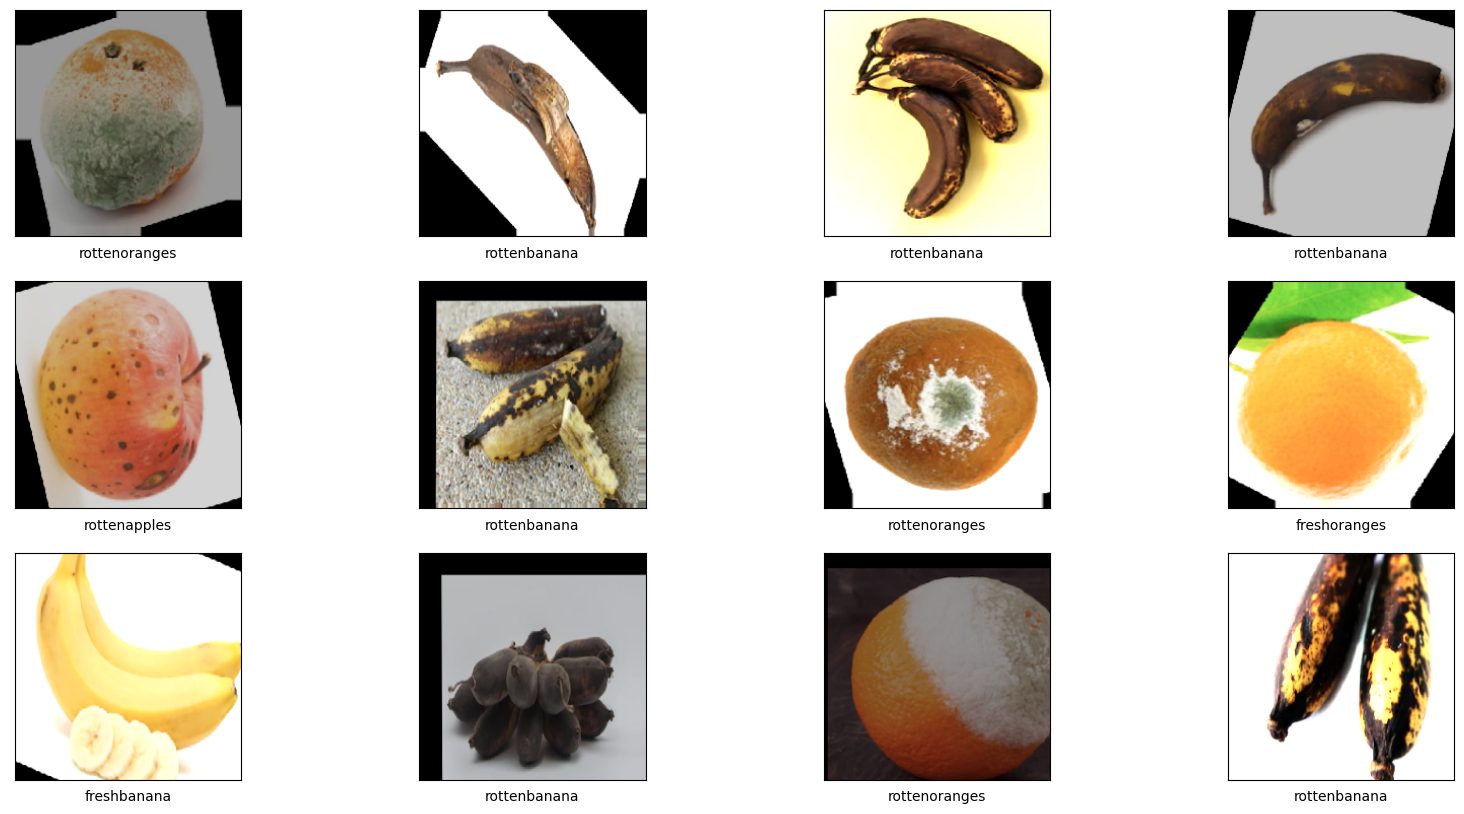

In [4]:
#get classes dict 
classes_dict = dict(test_gen.class_indices)
#reverse 
classes_dict = {v: k for k,v in classes_dict.items()}
#let's plot sone images 
images,labels=train_gen.next()
plt.figure(figsize=(20,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes_dict[labels[i]])

# Building Model

In [5]:
#create Inception Model 
inception = InceptionV3(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
#show the base model summary 
inception.summary()
#show how manay layers in the Resnet Network
layers = inception.layers
print(f'Number of Layers: {len(layers)}')

#memvisualisasikan beberapa gambar dari dataset pelatihan dengan label kelas yang sesuai,
#menggunakan kamus classes_dict untuk mengonversi indeks kelas menjadi label kelas.

87910968/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

# Training Model

In [6]:
# Variabel ini menghitung jumlah sampel dalam set pelatihan dan set pengujian
TRAIN_SIZE = train_gen.samples
TEST_SIZE = test_gen.samples
# early stopping = Callback ini akan menghentikan pelatihan jika akurasi validasi tidak meningkat setelah 3 epoch berturut-turut.
callbacks = EarlyStopping(patience = 3, monitor='val_acc')
                        
# train our Model 
inputs = inception.input
# get the output of inception NN and add an average pooling layer
x = inception.output
x = GlobalAveragePooling2D()(x)
# add the a dense layer
x = Dense(512, activation='relu')(x)
# add a dropout 
x = Dropout(0.5)(x)
# finally, add an output layer
outputs = Dense(6, activation ='softmax')(x)
# build the model to train 
model = Model(inputs=inputs, outputs=outputs)

# freeze all convolutional inception layers
for layer in layers:
    layer.trainable = False

# compile the model 
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# train the model for 10 epochs 
history = model.fit_generator(
                train_gen,
                epochs= EPOCHS,
                validation_data = test_gen,
                validation_steps = TEST_SIZE//BATCH_SIZE,
                steps_per_epoch = TRAIN_SIZE//BATCH_SIZE,
                callbacks = [callbacks])

/tmp/ipykernel_23/921762039.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
340/340 [==============================] - 371s 1s/step - loss: 0.2746 - accuracy: 0.9003 - val_loss: 0.0775 - val_accuracy: 0.9706
Epoch 2/30
340/340 [==============================] - 195s 572ms/step - loss: 0.1554 - accuracy: 0.9450 - val_loss: 0.0846 - val_accuracy: 0.9706
Epoch 3/30
340/340 [==============================] - 196s 575ms/step - loss: 0.1227 - accuracy: 0.9572 - val_loss: 0.0513 - val_accuracy: 0.9818
Epoch 4/30
340/340 [==============================] - 191s 562ms/step - loss: 0.1171 - accuracy: 0.9562 - val_loss: 0.0584 - val_accuracy: 0.9769
Epoch 5/30
340/340 [==============================] - 194s 570ms/step - loss: 0.0943 - accuracy: 0.9689 - val_loss: 0.0387 - val_accuracy: 0.9844
Epoch 6/30
340/340 [==============================] - 191s 562ms/step - loss: 0.0936 - accuracy: 0.9671 - val_loss: 0.0470 - val_accuracy: 0.9818
Epoch 7/30
340/340 [==============================] - 196s 577ms/step - loss: 0.0909 - accuracy: 0.9691 - val_loss: 0.0645 - va

Text(0.5, 0, 'N.of Epochs')

<Figure size 640x480 with 0 Axes>

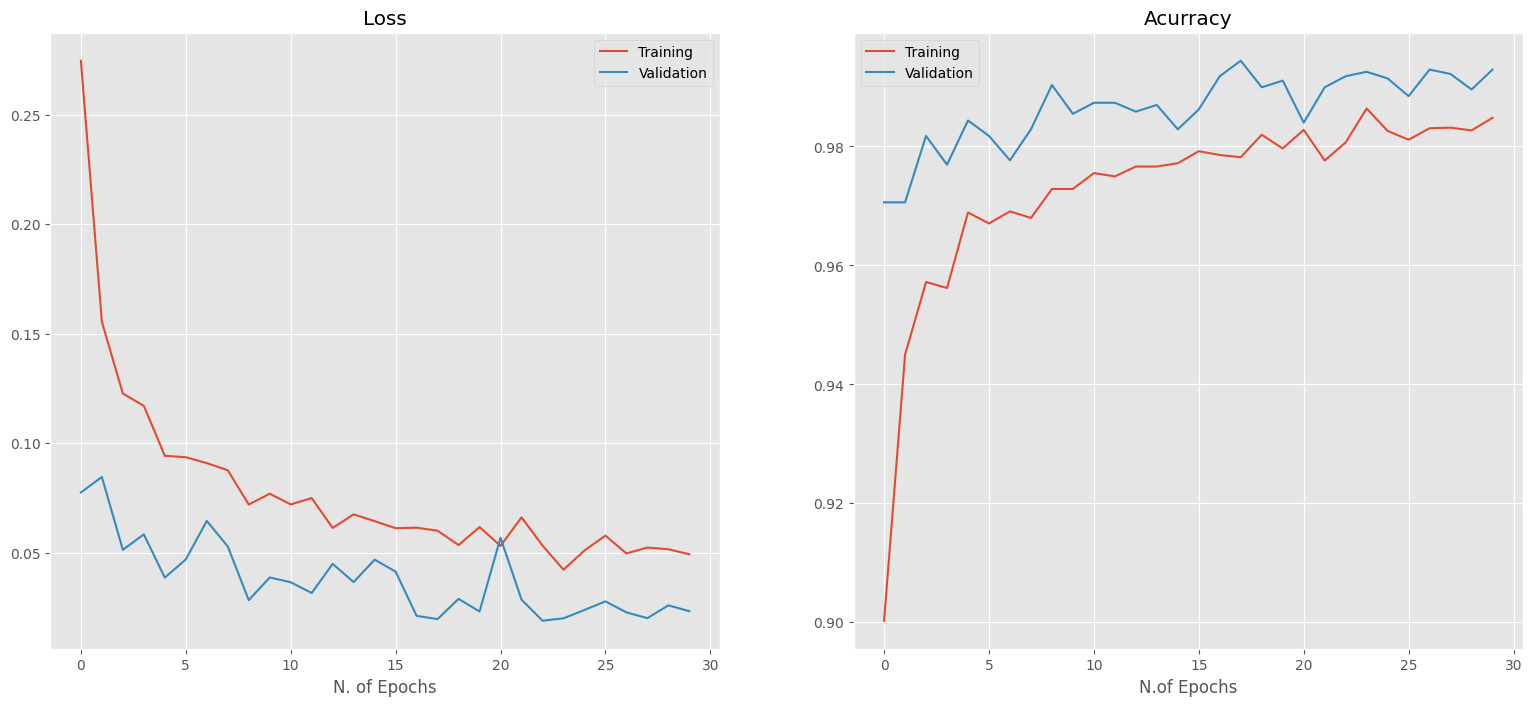

In [7]:
# Plot training loss vs validation loss
plt.style.use('ggplot') # Mengatur gaya plot menggunakan gaya "ggplot". Ini akan memberikan tampilan yang konsisten dengan gaya plot ggplot dari paket R.
plt.figure() #Membuat sebuah figure baru untuk menampung plot yang akan digunakan.
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8)) #Membuat subplot dengan 1 baris dan 2 kolom. ax1 dan ax2 adalah objek axes yang mewakili masing-masing subplot. Figsize ditentukan sebagai (19,8), yang mengatur ukuran gambar.
ax1.plot(history.history['loss']) 
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('N. of Epochs')
## plot training accuracy vs validation accuracy 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('N.of Epochs')

# Evaluate

In [8]:
#Evaluate
loss, test_acc = model.evaluate(test_gen) # Menggunakan metode evaluate dari model untuk menghitung loss dan akurasi pada dataset pengujian (test_gen). Metode ini mengembalikan nilai loss dan akurasi yang disimpan dalam variabel loss dan test_acc secara berturut-turut.
print("Validation Accuracy = %f \nValidation Loss = %f " % (test_acc, loss)) #Mencetak hasil evaluasi model, yaitu akurasi dan loss pada dataset pengujian. Format string digunakan untuk mencetak nilai akurasi dan loss dengan presisi desimal menggunakan %f. Akurasi dicetak sebagai "Validation Accuracy" dan loss dicetak sebagai "Validation Loss".

85/85 [==============================] - 16s 182ms/step - loss: 0.0240 - accuracy: 0.9926
Validation Accuracy = 0.992587 
Validation Loss = 0.024003 


# Testing

1/1 [==============================] - 0s 28ms/step


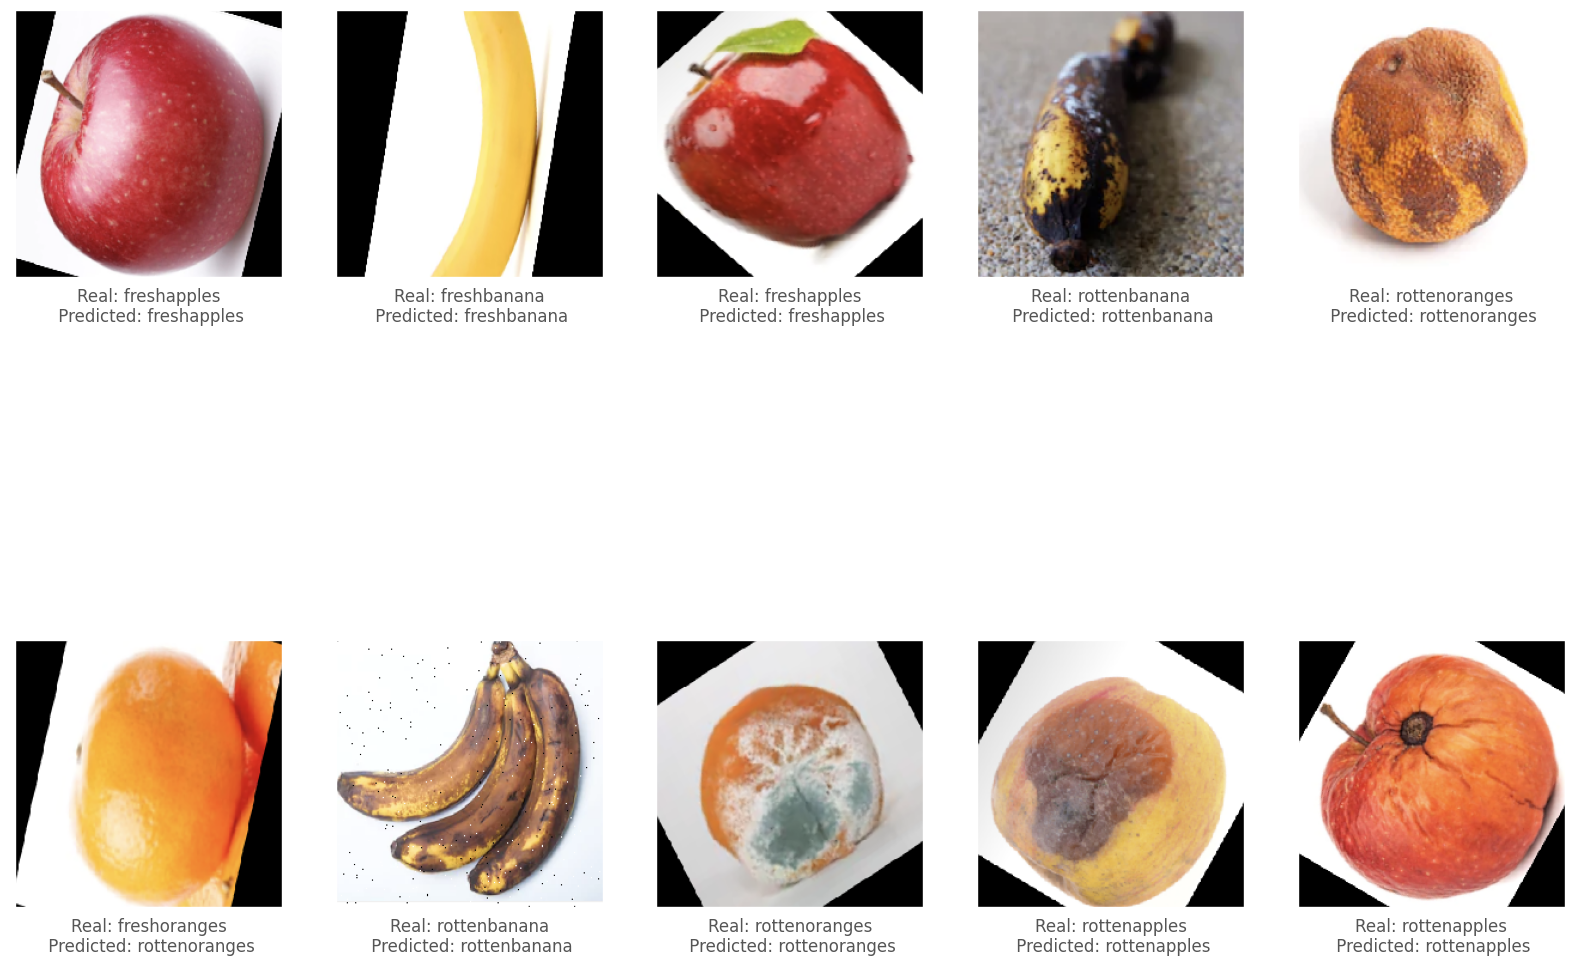

In [9]:
test_images,test_labels=test_gen.next()
plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
    real = classes_dict[test_labels[i]]
    img = test_images[i].reshape(1,224,224,3)
    predicted = int(np.argmax(model.predict(img),axis=1))
    predicted = classes_dict[predicted]
    plt.xlabel(f"Real: {real}\n Predicted: {predicted}")

In [10]:
## Xception


In [11]:

xception = Xception(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

xception.summary()
#show how many layers in the Xception Network
layers = xception.layers
print(f'Number of Layers: {len(layers)}')

83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [12]:
# number of samples for each set
TRAIN_SIZE = train_gen.samples
TEST_SIZE = test_gen.samples
# early stopping
callbacks = EarlyStopping(patience=3, monitor='val_acc')

# let's train our Model
inputs = xception.input
# get the output of Xception and add an average pooling layer
x = xception.output
x = GlobalAveragePooling2D()(x)
# add a dense layer
x = Dense(512, activation='relu')(x)
# add dropout
x = Dropout(0.5)(x)
# finally, add an output layer
outputs = Dense(6, activation='softmax')(x)
# build the model to train
model = Model(inputs=inputs, outputs=outputs)

# freeze all convolutional Xception layers
for layer in layers:
    layer.trainable = False

# compile the model
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# train the model for 5 epochs
history = model.fit_generator(
                train_gen,
                epochs=EPOCHS,
                validation_data=test_gen,
                validation_steps=TEST_SIZE//BATCH_SIZE,
                steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
                callbacks=[callbacks])

/tmp/ipykernel_23/2393335688.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
340/340 [==============================] - 211s 610ms/step - loss: 0.1911 - accuracy: 0.9292 - val_loss: 0.0627 - val_accuracy: 0.9773
Epoch 2/30
340/340 [==============================] - 207s 607ms/step - loss: 0.1071 - accuracy: 0.9604 - val_loss: 0.0549 - val_accuracy: 0.9818
Epoch 3/30
340/340 [==============================] - 198s 582ms/step - loss: 0.0937 - accuracy: 0.9667 - val_loss: 0.0445 - val_accuracy: 0.9814
Epoch 4/30
340/340 [==============================] - 198s 582ms/step - loss: 0.0772 - accuracy: 0.9724 - val_loss: 0.0390 - val_accuracy: 0.9855
Epoch 5/30
340/340 [==============================] - 203s 598ms/step - loss: 0.0740 - accuracy: 0.9739 - val_loss: 0.0466 - val_accuracy: 0.9844
Epoch 6/30
340/340 [==============================] - 197s 579ms/step - loss: 0.0652 - accuracy: 0.9764 - val_loss: 0.0396 - val_accuracy: 0.9862
Epoch 7/30
340/340 [==============================] - 202s 594ms/step - loss: 0.0689 - accuracy: 0.9760 - val_loss: 0.0350 -

Text(0.5, 0, 'N.of Epochs')

<Figure size 640x480 with 0 Axes>

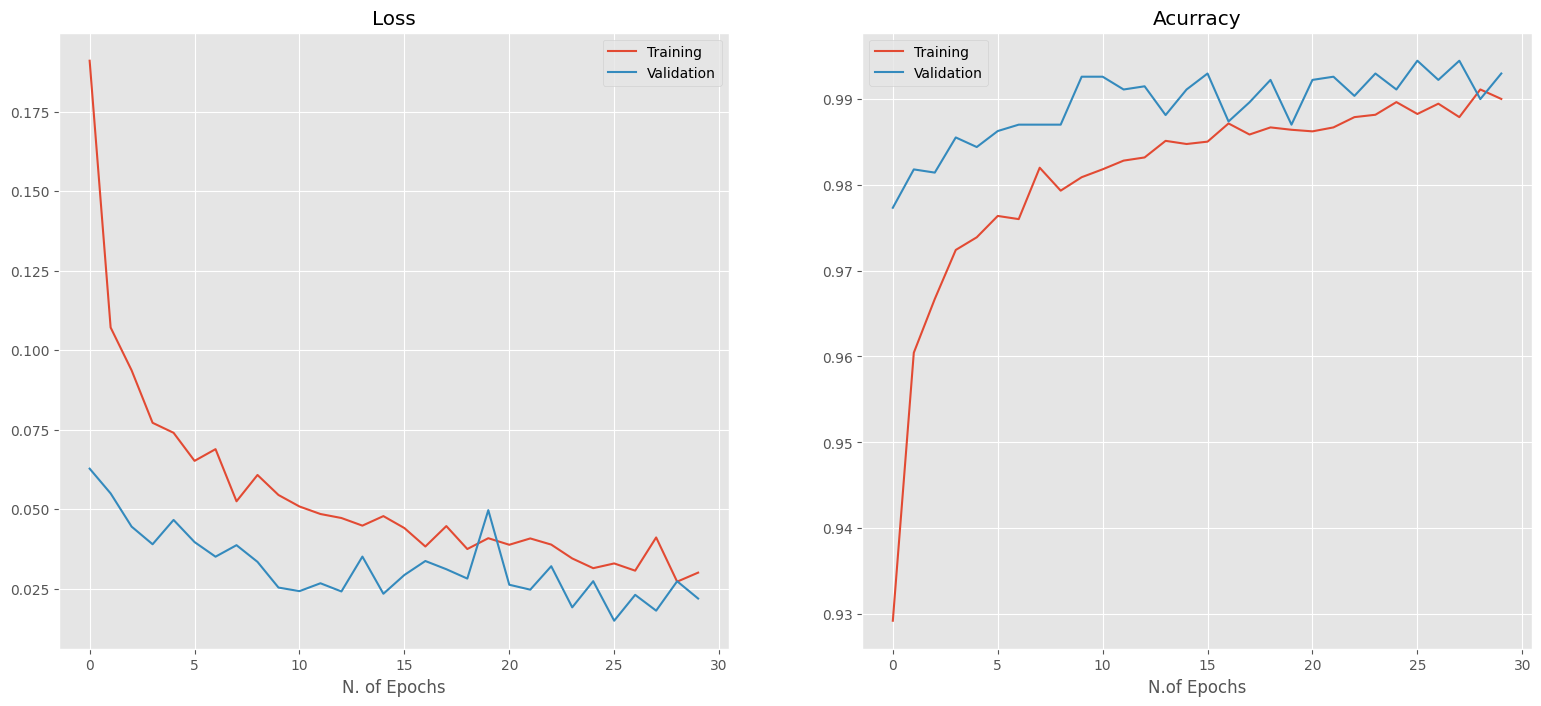

In [13]:
# Plot training loss vs validation loss
plt.style.use('ggplot')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('N. of Epochs')
## plot training accuracy vs validation accuracy 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('N.of Epochs')

In [14]:
#Evaluate
loss, test_acc = model.evaluate(test_gen)
print("Validatio Accuracy = %f \nValidation Loss = %f " % (test_acc, loss))

85/85 [==============================] - 15s 181ms/step - loss: 0.0218 - accuracy: 0.9930
Validatio Accuracy = 0.992958 
Validation Loss = 0.021794 


1/1 [==============================] - 0s 23ms/step


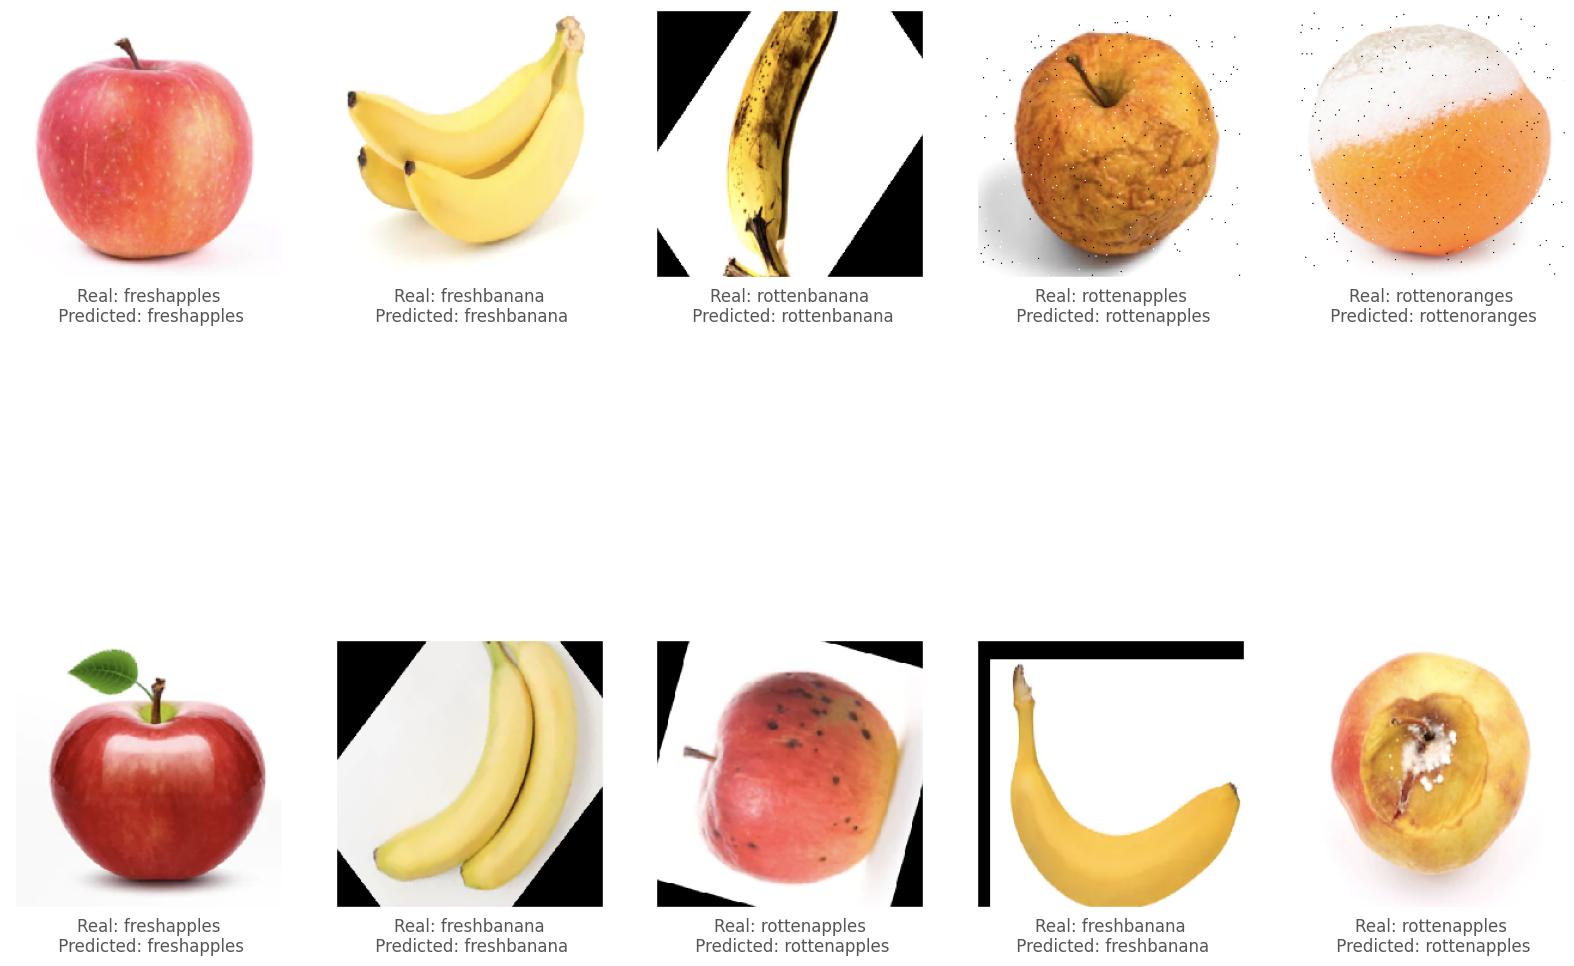

In [15]:

test_images,test_labels=test_gen.next()
plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
    real = classes_dict[test_labels[i]]
    img = test_images[i].reshape(1,224,224,3)
    predicted = int(np.argmax(model.predict(img),axis=1))
    predicted = classes_dict[predicted]
    plt.xlabel(f"Real: {real}\n Predicted: {predicted}")